<a href="https://colab.research.google.com/github/Brian-Mwangi-developer/AI_development/blob/main/GAN_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.show()

In [2]:
!pip install pytorch-lightning

In [3]:
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt

import pytorch_lightning as pl

random_seed = 42
torch.manual_seed(random_seed)

BATCH_SIZE=128
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count() / 2)


In [4]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data",
                 batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose( #Chains Multiple Transformations
            [
                transforms.ToTensor(),# transforms from Numpy Array to tensors
                transforms.Normalize((0.1307,), (0.3081,)),# normalization helps the model train faster by ensuring the data  is centered and has similar scales
            ]
        )

    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])# split the mnist full into training 55,000 and val=5000

        # Assign test dataset
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

In [5]:
# Detective: fake or no fake -> 1 output [0, 1]
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # Simple CNN
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)#1 represents channel input(grayscale)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Flatten the tensor so it can be fed into the FC layers
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [6]:
# Generate Fake Data: output like real data [1, 28, 28] and values -1, 1
class Generator(nn.Module):
    def __init__(self, latent_dim):# Latent_dim: The size of the random input noise (latent vector)
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7*7*64)  # [n, 256, 7, 7]
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2) # [n, 64, 16, 16] #Upsamples the image increasing size
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2) # [n, 16, 34, 34]
        self.conv = nn.Conv2d(16, 1, kernel_size=7)  # [n, 1, 28, 28]  #Reduces the feature map to a single channel grayscale image


    def forward(self, x):
        # Pass latent space input into linear layer and reshape
        x = self.lin1(x) #pass the noise through a linear layer
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7)  #256  # Reshape into 64 channels of size 7x7

        # Upsample (transposed conv) 16x16 (64 feature maps)
        x = self.ct1(x)
        x = F.relu(x)

        # Upsample to 34x34 (16 feature maps)
        x = self.ct2(x)
        x = F.relu(x)

        # Convolution to 28x28 (1 feature map)
        return self.conv(x) # Final convolution to output a 1-channel image

#GAN

In [7]:
class GAN(pl.LightningModule):
    def __init__(self,latent_dim=100, lr=0.002):
       super().__init__()
       self.save_hyperparameters()
       self.generator = Generator(latent_dim=self.hparams.latent_dim) # Instantiate the generator
       self.discriminator = Discriminator()

       #random noise
       self.validation_z = torch.randn(6, self.hparams.latent_dim)  # Sample 6 random noise vectors
         #set automatic optimization to false
       self.automatic_optimization = False

    def forward(self,z):
      return self.generator(z)

    def adversarial_loss(self, y_hat, y):
      return F.binary_cross_entropy(y_hat, y)   # Calculate binary cross-entropy loss

    def training_step(self, batch, batch_idx):
      real_imgs, _ = batch  # Unpack real images from the batch

      #sample noise
      z= torch.randn(real_imgs.shape[0], self.hparams.latent_dim) # Sample random noise
      z=z.type_as(real_imgs) # Ensure the noise tensor is on the same device as real images

      #train generator :max log(D(G(z)))
      opt_g, opt_d = self.optimizers() # get optimizers

      #generate images
      fake_imgs = self(z)
      yhat = self.discriminator(fake_imgs) # Classify fake images
      y = torch.ones(real_imgs.size(0), 1) # Real label for fake images

      y = y.type_as(real_imgs)

      g_loss = self.adversarial_loss(yhat, y)  # Calculate generator loss

      #manually perform backpropagation and optimization
      opt_g.zero_grad() # Reset gradients
      self.manual_backward(g_loss) # Compute gradients
      opt_g.step()  # Update generator parameters

      log_dict = {"g_loss": g_loss}  # Log generator loss


        #how well can it label as real
      yhat_real = self.discriminator(real_imgs) # Classify real images

      y_real = torch.ones(real_imgs.size(0), 1)  # Real label for real images
      y_real = y_real.type_as(real_imgs)

      real_loss = self.adversarial_loss(yhat_real, y_real) # Compare and calculate loss for real image

      # how well can it label as fake
      yhat_fake = self.discriminator(self(z).detach())  # Classify real images
      y_fake = torch.zeros(real_imgs.size(0), 1) # Real label for real images
      y_fake = y_fake.type_as(real_imgs)

      fake_loss = self.adversarial_loss(yhat_fake, y_fake)
      d_loss = (real_loss + fake_loss) / 2  # Average loss for the discriminator
      log_dict = {"d_loss": d_loss}
      return {"loss": d_loss,"progress_bar":log_dict,"log": log_dict}

      #Adam Optimizer: An adaptive learning rate optimization algorithm
    def configure_optimizers(self):
      lr=self.hparams.lr # Get the learning rate
      opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr) # Adam optimizer for the generator
      opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr)  # Adam optimizer for the discriminator
      return [opt_g, opt_d], []  # Return the optimizers

    def plot_imgs(self):
      z = self.validation_z.type_as(self.generator.lin1.weight)  # Get validation noise on the right device
      sample_imgs =self(z).cpu() # Generate sample images
      print(sample_imgs.shape)
      print('epoch',self.current_epoch)
      fig =plt.figure()
      for i in range(sample_imgs.size(0)):
        plt.subplot(2,3,i+1) # Create subplots
        plt.tight_layout() # Adjust subplot
        plt.imshow(sample_imgs.detach()[i,0,:,:], cmap="gray_r", interpolation ="none")  # Display generated image
        plt.title("Generated Data")  # Title for each subplot
        plt.xticks([])
        plt.yticks([])
        plt.axis("off")
      plt.tight_layout()  # Adjust subplot layout
      plt.savefig(f"generated_images_epoch_{self.current_epoch}.png")  # Save the figure
      plt.show()
      plt.close(fig)  # Close the figure to prevent figure accumulation during training

    def on_epoch_end(self):
     # Plot generated images at the end of each epoch
     print(f"Epoch {self.current_epoch} ended, plotting images...")
     self.plot_imgs()

In [8]:
dm = MNISTDataModule() # Create an instance of the data module
model = GAN()  # Create an instance of the GAN model


torch.Size([6, 1, 28, 28])
epoch 0


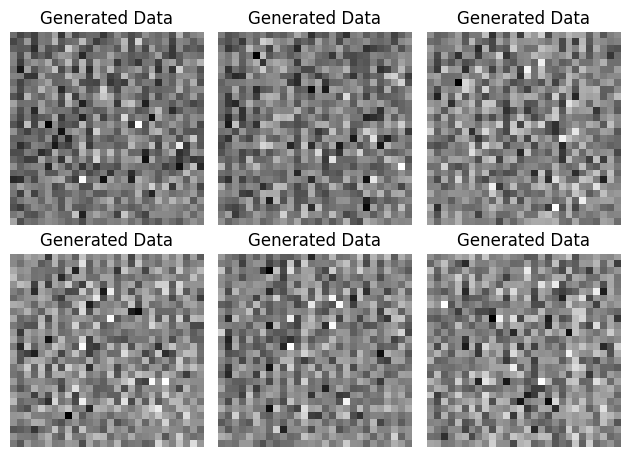

In [9]:
model.plot_imgs() # Plot initial generated images (before training)

In [10]:
class ImageLogger(pl.Callback):
    def __init__(self, model):
        self.model = model

    def on_epoch_end(self, trainer, pl_module):
        print(f"Logging images for epoch {trainer.current_epoch}")
        self.model.plot_imgs()



In [11]:
image_logger = ImageLogger(model)
trainer = pl.Trainer(accelerator="gpu", devices=AVAIL_GPUS, max_epochs=3, callbacks=[image_logger])
trainer.fit(model, dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 358 K  | train
1 | discriminator | Discriminator | 21.4 K | train
--------------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)
11        Modules in train mode
0         Modul

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.
